In [2]:
import openpyxl 
import os
import cv2
import pytesseract
import tensorflow as tf
import numpy as np
# from imutils.perspective import four_point_transform
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
# from easyocr import easyocr
from pathlib import Path

pytesseract.pytesseract.tesseract_cmd = r"/mnt/c/Program Files/Tesseract-OCR/tesseract.exe"


ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
DATASET_PATH = f'dataset'
# READER = easyocr.Reader(['en'])

# type decls
cv2.Image = np.ndarray

# shows an image on ipynb
def imshow(img: cv2.Image) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Get all testing images into an array

In [36]:
images = []
for (id, filename) in enumerate(os.listdir(DATASET_PATH)):
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    images.append((filename, image))

Defines image cropper to center the text in the image

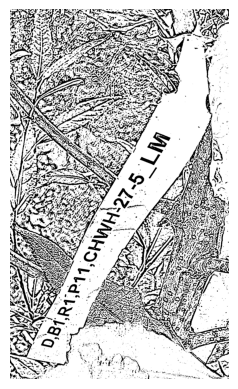

In [73]:
def process_image(img: cv2.Image) -> cv2.Image:
    gray = grayscale(img)
    blur = cv2.medianBlur(gray, 5)
    blur = image.img_to_array(blur, dtype='uint8')
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
    return thresh

def crop_image(img: cv2.Image, display_contour: bool = False) -> cv2.Image:

    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (71, 71), 0)
    ret, thresh = cv2.threshold(blur,150,255,0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    big_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    if display_contour:
        drawn_contours = cv2.drawContours(img.copy(), [big_contour], -1, (0, 0, 255), 5)
        imshow(drawn_contours)

    x, y, w, h = cv2.boundingRect(big_contour) 
    newimg = img[y:y+h, x:x+w]

    # perimeter = cv2.arcLength(big_contour, True)
    # approx = cv2.approxPolyDP(big_contour, 0.04*perimeter, True)
    # print(len(approx))
    # newimg = four_point_transform(img, approx.reshape(4, 2))

    return newimg

test_index = 8
img = crop_image(images[test_index][1], display_contour=False)
img = process_image(img)
imshow(img)

Generate synthetic data to train neural network

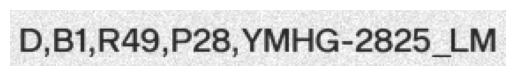

In [68]:
from trdg.generators import GeneratorFromStrings
import random

def get_random_text():
    treatment = random.choice(['C', 'D'])
    block = f"B{random.choice(['1', '2'])}"
    row = f"R{random.randint(1, 99)}"
    position = f"P{random.randint(1, 99)}"
    
    gen_length = random.randint(2, 4)
    num_count = random.choices([1, 2, 3], weights=(70, 15, 15))[0]
    num_lengths = random.choices([1, 2, 3, 4], weights=(15, 15, 15, 55), k=num_count)

    genotype = (
        "".join([ALPHABET[random.randint(0, 25)] for _ in range(gen_length)]) + 
        f"-{'-'.join([str(random.randint(10**(i-1), 10**i-1)) for i in num_lengths])}_LM"
    )

    return ','.join([treatment, block, row, position, genotype])

# delete all present images
os.system('mkdir examples')
if os.name == 'nt':
    os.system('del examples/*') 
else:
    os.system('rm examples/*')

# generate the new images, limiting count
IMG_COUNT = 100
generator = GeneratorFromStrings(
    [get_random_text() for _ in range(1000)],
    random_blur=True,
    random_skew=True,
    background_type=0
)
i = 0
for img, lbl in generator:
    if i == IMG_COUNT: break
    img.save(f'examples/{lbl}.png')
    i += 1
example_img = random.choice(os.listdir('examples'))
imshow(cv2.imread(f"examples/{example_img}"))

# ignore image directory
with open("examples/.gitignore", 'w') as f:
    f.write('*')

Delete all the examples if needed